# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Preprocessing

1.   Loading dataset
2.   Dropping duplicates
3.   Viewing dataset summary

In [ ]:
df = pd.read_csv('UpdatedResumeDataSet.csv',encoding='utf-8')
df.drop_duplicates()
df.describe().T

**Increasing some class sizes to ensure balanced dataset**

In [ ]:
maxsize = df['Category'].value_counts().max()
balanced_df = df.groupby('Category').apply(lambda x: x.sample(maxsize, replace=True)).reset_index(drop=True)
df = balanced_df.sample(frac=1).reset_index(drop=True)

**Cleaning Text by:**
1.   Removing URL's
2.   Removing hashtags
3.   Removing emails
4.   Removing punctation and non ASCII characters
5.   Using spaCy to lemmatize text
6.   Removing stop words, whitespaces and punctuattion
7.   Joining rest of the token into a single string

In [ ]:
nlp = spacy.load("en_core_web_sm")

def cleanresume(txt):
    cleantext = re.sub(r'http\S+\s?', ' ', txt)
    cleantext = re.sub(r'RT|cc', ' ', cleantext)
    cleantext = re.sub(r'#\S+\s?', ' ', cleantext)
    cleantext = re.sub(r'@\S+', ' ', cleantext)
    cleantext = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleantext)
    cleantext = re.sub(r'\S+@\S+', ' ', cleantext)
    cleantext = re.sub(r'[^\x00-\x7f]', ' ', cleantext)
    cleantext = re.sub(r'\s+', ' ', cleantext)
    cleantext = cleantext.strip().lower()
    doc = nlp(cleantext)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    cleantext = ' '.join(tokens)
    return cleantext

df['Resume'] = df['Resume'].apply(cleanresume)
print(df['Resume'].head)

# Extracting tabular Data

**Generating the Tabular data for Multimodal approach**


1.   Extracts degree if it sees keywords
2.   Extracts years of experience
3.   Extracts 'skills', separates hard skills(100% weight) and soft skills (20% weight)



In [ ]:
def extractfeatures(df):
    df['experience'] = df['Resume'].str.extract(r'(\d+)\s+years?', expand=False).fillna(0).astype(int)

    def get_degree(text):
        text = text.lower()
        if 'phd' in text or 'doctorate' in text:
            return 3
        elif 'master' in text or 'msc' in text:
            return 2
        elif 'bachelor' in text or 'bsc' in text:
            return 1
        return 0
    df['degree'] = df['Resume'].apply(get_degree)

    hard_skills = [
        'python', 'java', 'c++', 'sql', 'javascript', 'html', 'css',
        'aws', 'azure', 'docker', 'kubernetes', 'linux', 'ubuntu',
        'tensorflow', 'pytorch', 'machine learning', 'deep learning',
        'data analysis', 'nlp', 'excel', 'power bi', 'tableau',
        'git', 'bash', 'google analytics'
    ]

    soft_skills = [
        'communication', 'leadership', 'teamwork', 'adaptability',
        'problem solving', 'critical thinking', 'time management',
        'creativity', 'attention to detail', 'interpersonal skills', 'presentation', 'strategizing', 'marketing'
    ]


    def count_skills(text):
        text = text.lower()
        hard_count = sum(skill in text for skill in hard_skills)
        soft_count = sum(skill in text for skill in soft_skills) * 0.2
        return hard_count + soft_count

    df['skills'] = df['Resume'].apply(count_skills)
    return df

df = extractfeatures(df)
df.head()
df.tail()

# Generating Synthetic Labels



1.   Creating a hypothetical job description
2.   Checking semantic similarity (cosine similarity) of the resume text to the job description and labelling based on that



In [ ]:
jobdescription = """
We're hiring a Machine Learning Engineer with:
- 3+ years experience in Python and ML
- Master's or PhD in Computer Science
- Expertise in deep learning frameworks (TensorFlow/)
- Strong NLP and data analysis skills
- some soft skills like communication
"""
cleanedjd = cleanresume(jobdescription)

def generatelabels(df, jd) :
    corpus = df['Resume'].to_list() + [jd]
    vectorizer = TfidfVectorizer()
    tfidfmatrix = vectorizer.fit_transform(corpus)
    similarities = cosine_similarity(tfidfmatrix[-1], tfidfmatrix[:-1])[0]
    threshold = np.quantile(similarities, 0.7)
    return (similarities>=threshold).astype(int)

df['shortlisted'] = generatelabels(df, cleanedjd)
df.head()
df['shortlisted'].value_counts()

# Generating vector embeddings for the text

In [ ]:
vectorizer = TfidfVectorizer()
tfidfmatrix = vectorizer.fit_transform(df['Resume'])
embeddings_array = tfidfmatrix.toarray()
# df['embeddings'] = [row for row in embeddings_array]

print(embeddings_array.shape)

In [ ]:
df = df.loc[:, ~df.columns.str.startswith('pca_')]
pca = PCA(n_components=0.95)
reducedembeddings = pca.fit_transform(embeddings_array)

pcadf = pd.DataFrame(reducedembeddings, columns=[f'pca_{i+1}' for i in range(reducedembeddings.shape[1])])
df = pd.concat([df.reset_index(drop=True), pcadf.reset_index(drop=True)], axis=1)
# df.drop(columns=['embedding', 'embeddings', 'tfidf_vector'], inplace=True)
df.head()

In [42]:
x = df.iloc[:,7:]
y = df['shortlisted']
# xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)
# xtraincnn = xtrain.values.reshape(-1, 134, 1)
# xtestcnn = xtest.values.reshape(-1, 134, 1)
xtab = df.iloc[:,2:5]
# xtraintab, xtesttab = train_test_split(x, test_size=0.3)

In [43]:
indices = np.arange(len(x))
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)

xtraincnn = x.iloc[train_idx].values.reshape(-1, 134, 1)
xtestcnn = x.iloc[test_idx].values.reshape(-1, 134, 1)

xtraintab = xtab.iloc[train_idx].values
xtesttab = xtab.iloc[test_idx].values

ytrain = y.iloc[train_idx]
ytest = y.iloc[test_idx]

In [44]:
tabular_input = Input(shape=(xtraintab.shape[1],))  # Match input shape to number of features
ycnn = layers.Dense(64, activation='relu')(tabular_input)
ycnn = layers.Dense(32, activation='relu')(ycnn)

In [ ]:
input_layer = layers.Input(shape=(134, 1))

In [47]:
class SafeAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        query, value = inputs
        # Compute attention scores
        scores = tf.matmul(query, value, transpose_b=True)

        # Only apply softmax if dimension > 1
        dim = tf.shape(scores)[-1]
        scores = tf.cond(
            tf.greater(dim, 1),
            lambda: tf.nn.softmax(scores, axis=-1),
            lambda: scores / (tf.reduce_sum(scores, axis=-1, keepdims=True) + 1e-8)
        )

        return tf.matmul(scores, value)

    def compute_output_shape(self, input_shape):
        # Correct output shape calculation
        query_shape, value_shape = input_shape
        return (query_shape[0], query_shape[1], value_shape[2])

In [ ]:
text_features = layers.Dense(64)(input_layer)
tabular_features = layers.Dense(64)(tabular_input)
tabular_features = layers.Reshape((1, 64))(tabular_features)

attention_output = SafeAttention()([text_features, tabular_features])
combined = layers.Concatenate()([text_features, attention_output])
z = layers.GlobalAveragePooling1D()(combined)
z = layers.Dense(32, activation='relu')(z)

In [ ]:
final_output = layers.Dense(1, activation='sigmoid')(z)

In [50]:
loss = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True,
    alpha=0.2,
    gamma=3.0,
    from_logits=False
)

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_precision',
        patience=5,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_precision',
        save_best_only=True,
        mode='max'
    )
]


class_weights = {0: 1, 1: 3}

In [51]:
model = tf.keras.Model(inputs=[input_layer, tabular_input], outputs=final_output)
model.compile(optimizer='adam', loss=loss, metrics=metrics)
model.fit([xtraincnn, xtraintab], ytrain, epochs= 10, class_weight=class_weights, callbacks=callbacks)
model.evaluate([xtestcnn, xtesttab], ytest)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6154 - loss: 0.2648 - precision: 0.4042 - recall: 0.4907
Epoch 2/10
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6908 - loss: 0.1134 - precision: 0.5740 - recall: 0.0760

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_precision` which is not available. Available metrics are: accuracy,loss,precision,recall
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_precision available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6958 - loss: 0.1081 - precision: 0.5912 - recall: 0.0779
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7049 - loss: 0.1311 - precision: 0.5343 - recall: 0.0964
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6827 - loss: 0.0797 - precision: 0.2585 - recall: 0.0284
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6996 - loss: 0.1801 - precision: 0.5488 - recall: 0.0701
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7005 - loss: 0.1123 - precision: 0.7027 - recall: 0.1428
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7117 - loss: 0.0838 - precision: 0.6840 - recall: 0.1031
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7418 - loss: 0.0938 - precision: 0.8258 - recall: 0.1427
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7151 - loss: 0.0664 - precision: 0.5135 - recall: 0.3586
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━

[0.0813322588801384,
 0.7231833934783936,
 0.7647058963775635,
 0.14606741070747375]

In [ ]:
y_pred_probs = model.predict([xtestcnn, xtesttab])
precisions, recalls, thresholds = precision_recall_curve(ytest, y_pred_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
y_pred_optimized = (y_pred_probs > optimal_threshold).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Optimal threshold: 0.428


In [60]:
print("Accuracy:", accuracy_score(ytest, y_pred_optimized))
print("Precision:", precision_score(ytest, y_pred_optimized))
print("Recall:", recall_score(ytest, y_pred_optimized))
print("F1 Score:", f1_score(ytest, y_pred_optimized))

Accuracy: 0.7474048442906575
Precision: 0.58
Recall: 0.651685393258427
F1 Score: 0.6137566137566137


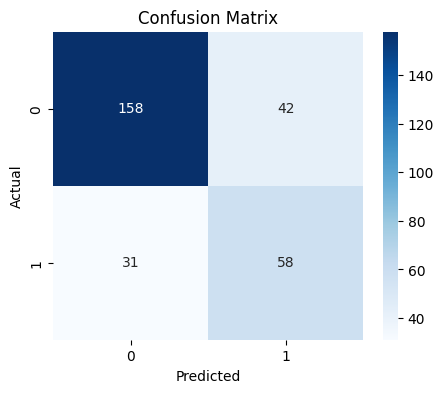

In [61]:
cm = confusion_matrix(ytest, y_pred_optimized)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

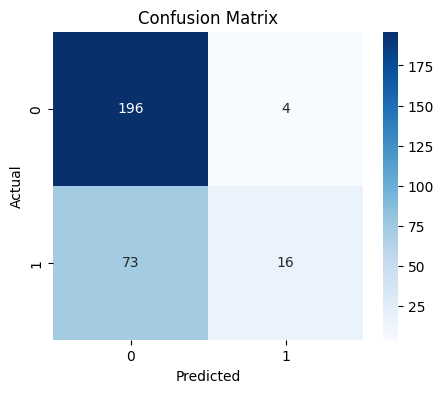

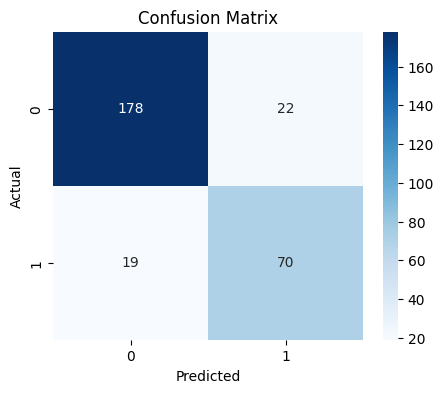

In [62]:
lr_model = LogisticRegression().fit(xtraintab, ytrain)
xgb_model = XGBClassifier().fit(xtraintab, ytrain)
ypredlr = lr_model.predict(xtesttab)
ypredxgb = xgb_model.predict(xtesttab)

cmlr = confusion_matrix(ytest, ypredlr)
plt.figure(figsize=(5,4))
sns.heatmap(cmlr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cmxgb = confusion_matrix(ytest, ypredxgb)
plt.figure(figsize=(5,4))
sns.heatmap(cmxgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()